# BackPropagation The Multi Layer Perceptron and Data Preperation

Now that we have demonstrated the basics of gradient descent, we can begin with some actual Machine Learning by implementing the Multi Layer Perceptron. In many resources, Logistic Regression is covered before the MLP due to the derivatives used there. I've chosen a different route, I believe that explaning how MLPs work with basic Regression prior to the introduction of classification is a more sensible approach. 


# Explaining the Multi Layer Perceptron
The MLP can really be thought of as a function consisting of multiple regression layers. Regression being the key here because the MLP often has an activation function, which is some function that is applied to introduce $non-linearity$ to the function. Activations are a major key seperator between a Neural Network and Linear Regression. Neural Networks in general are considered Universal Function Approximators. Meaning that given any unknown function, eventually with enough data a Neural Network will converge to the unknown function. Activation functions play a key role in this, because in the subset of all functions most are non linear. For example, attempting to converge to the function $$f(x) = Sin(x)$$ would be impossible due to its curvature, and the fact its derivative is $$ \frac{d}{dx} Sin(x) = Cos(x)$$

Text(0, 0.5, 'Sin(x)')

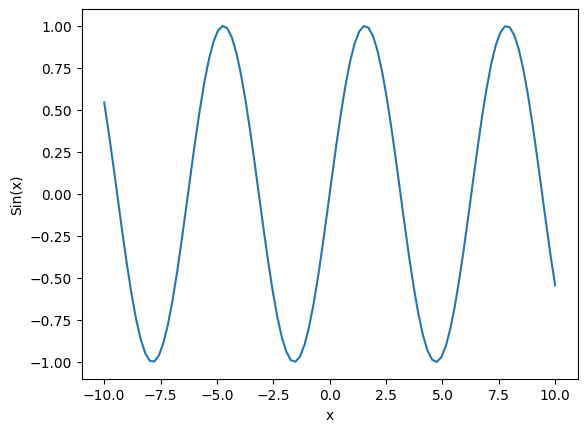

In [1]:
import matplotlib.pyplot as plt 
import numpy as np 

fa = np.linspace(-10, 10, 100) 


a = np.sin(fa)
plt.plot(fa, a) 
plt.xlabel("x") 
plt.ylabel("Sin(x)")

## Activation Functions

### The Sigmoid Activation Function

The first activation function most people are introduced to is the Sigmoid defined as such $$\sigma(x) = \frac{1}{1 + e^{-x}}$$. For derivation reasons it's also important to know that the sigmoid can be represented as $$\sigma(x) = \frac{e^x}{1+e^x}$$ Its introduction is usually first because it has a nice property of binding any input to numbers between 0-1 as can be seen in this graph


Importantly, the sigmoid function is NOT a Linear Map. This can be shown by demonstrating it does not perserve additivity or homogeneity.
Showing sigmoid fails additivity:
$$\sigma(.5) + \sigma(.4) = 1.22$$
$$\sigma(.5 + .4) = .71$$

Showing sigmoid fails homogeneity:
$$\sigma(3 *.5 ) = .71$$
$$3 * \sigma(.5) = 1.8$$

In [2]:
# Implementing the sigmoid function
def sigmoid(x):
    return np.exp(x) / ( 1 + np.exp(x))


In [3]:
# Showing the sigmoid function is not a linear map
import numpy as np
assert not np.isclose(sigmoid(.5 + .4), (sigmoid(.5) + sigmoid(.4)), rtol=1e-05)
assert not np.isclose((3 * sigmoid(.5)), sigmoid(.5 * 3))

Text(0, 0.5, 'sigmoid(x)')

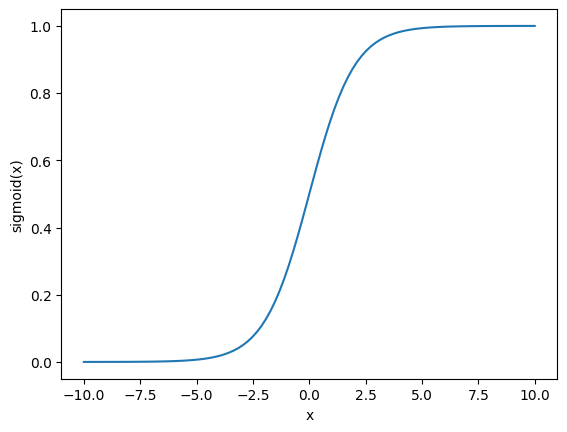

In [4]:
import matplotlib.pyplot as plt 
import numpy as np 

fa = np.linspace(-10, 10, 100) 


a = sigmoid(fa)
plt.plot(fa, a) 
plt.xlabel("x") 
plt.ylabel("sigmoid(x)")

The nonlinearity and binding of inputs end up making the sigmoid ideal for many problems, which we will cover later. For now we will focus on its effect within a standard regression model. For that we will need to compute the derivative of the Sigmoid function. This will be necessary so that we can use it during gradient descent in our updated Models

### Derivative of the Sigmoid Function

$$\sigma(x) = \frac{1}{1 + e^{-x}} | \sigma(x) = \frac{e^x}{(1 + e^x)}$$
$$\frac{d}{dx} = \frac{e^{x} (1 + e^x) - e^x e^x }{(1 + e^{x})^2}$$
$$\frac{d}{dx} = \frac{e^{x}  + e^{2x} - e^{2x} }{(1 + e^{x})^2}$$
$$\frac{d}{dx} = \frac{e^{x}}{(1 + e^{x})^2}$$
$$ \frac{d}{dx} = \frac{e^{x}}{1 + e^x} \frac{1}{1 + e^x}$$
$$ \frac{d}{dx} = \sigma(x) \frac{1}{1 + e^x}$$
$$ 1 - \sigma(x)  = 1 - \frac{e^x}{1 + e^x}$$
$$ 1 - \sigma(x) = \frac{1 + e^x}{1 + e^x} - \frac{e^x}{1 + e^x} $$
$$ 1 - \sigma(x) = \frac{1 }{1 + e^x} $$
$$ \frac{d}{dx} = \sigma(x) (1 - \sigma(x))$$

The simple derivative is an additional factor in why the sigmoid function is popular, autograd systems have to perform very little work in computing it, as it's a basic input -> output function. 

In [5]:
#implementing the derivative of the sigmoid function
sigmoid_derivative = lambda x: sigmoid(x) * (1 - sigmoid(x))



Text(0, 0.5, 'd/dx sigmoid(x)')

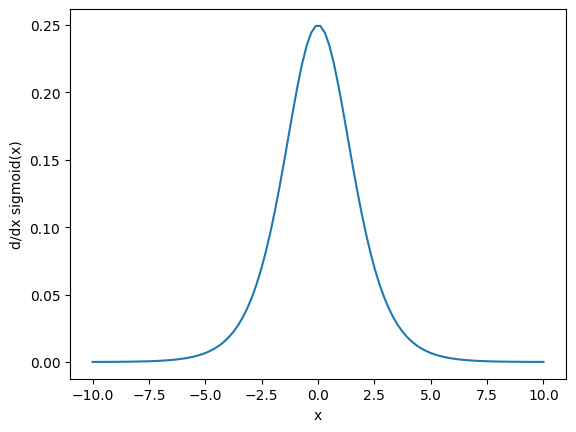

In [6]:
import matplotlib.pyplot as plt 
import numpy as np 
#graphing the derivative of the sigmoid function
fa = np.linspace(-10, 10, 100) 


a = sigmoid_derivative(fa)
plt.plot(fa, a) 
plt.xlabel("x") 
plt.ylabel("d/dx sigmoid(x)")

The sigmoid and its derivative can suffer from numerical instability under a few cricumstances, so for usage I will be including their stable versions here

In [7]:
def stable_sigmoid(x):
    return np.exp(-np.logaddexp(0, -x))

def sigmoid(x):
    return stable_sigmoid(x)

def sigmoid_derivative(x):
    s = sigmoid(x)
    return s * (1 - s)

## The Multi Layer Perceptron

Now that we have our activation function and derivative we are ready to discuss how the MLP truly works. Recall that $$\hat{y} = x \bullet w + b$$ The key improvement in the MLP is that instead of going straight to the output we add additional layers prior to the final predictor like so $$\hat{o} = x \bullet w_1 + b_1$$ $$\hat{y} = \sigma(\hat{o}) \bullet w_2 + b_2$$ more precisely a 2 layer MLP can be thought of like this $$\hat{y} =  \sigma(x \bullet w_1 + b_1) \bullet w_2 + b_2 $$ We can do this continously for an arbitrary number of layers so a three layer MLP would be described as $$\hat{y} = \sigma(\sigma(x \bullet w_1 + b_1) \bullet w_2 + b_2) \bullet w_3 + b_3$$

In [8]:
#Code for a single Layer
class Layer(object):
    def __init__(self,input_dimensions,output_dimensions):
        self.weights = np.random.randn(input_dimensions,output_dimensions)
        self.bias = np.random.randn(output_dimensions) 
        self.output_dimensions = output_dimensions
    def forward(self,x):
        return np.matmul(x,self.weights) + self.bias


In [9]:
class MultiLayerPerceptron(object):
    def __init__(self,input_dimensions,hidden_layers = [64,128], activation = sigmoid, activation_derivative = sigmoid_derivative):
        self.layers =[Layer(input_dimensions,hidden_layers[0])]
        #Create the layers
        for i in range(1 , len(hidden_layers) ):
            self.layers.append(Layer(self.layers[-1].output_dimensions,hidden_layers[i]))
        # Create the output Layer
        self.output_layer = Layer(self.layers[-1].output_dimensions,1)
        #Activation function
        self.activation = activation
        #derivative of the activation function
        self.activation_derivative = activation_derivative
    def forward(self,x):
        for layer in self.layers:
            x = self.activation(layer.forward(x))
        return self.output_layer.forward(x)

We now have a nice mathematical onion we can show why backpropagtion works. Each layer in the function has an independent input in regards to the next layer. That means that each layer can be seperately thought of similarly to how we view Linear regression with $$\hat{y} = \sigma(\sigma(x \bullet w_1 + b_1) \bullet w_2 + b_2) \bullet w_3 + b_3$$ $$\hat{y} =  \hat{o} \bullet w_3 + b_3 $$ 




The loss function can be described as $$MSE = \frac{1}{n}\sum (y - \hat{y})^2$$

With this we can begin to describe backpropagation, thanks to the independance of the final layer from its input we can know that  $$\nabla w_{3i} = \hat{o}_i  \frac{\partial L }{\hat{y}}$$

The gradient vector for the final layer can then be described as 
$$\nabla w_{3i} = \frac{\partial L}{\partial \hat{y}} \bullet \frac{\partial \hat{y}}{\partial \hat{o}}$$ 


$$\frac{\partial L}{\partial \hat{y}} =  \frac{2}{n} \sum (\hat{y} - y)$$
$$\frac{\partial \hat{y}}{\partial \hat{o}} = \hat{o_{i}}$$
Where $\hat{o_i}$ is the output of the previous layer with the activation applied


$$\nabla w_{3i} = \hat{o}_i \bullet \frac{2}{n} \sum (\hat{y} - y) $$ 

The gradient for $W_3$ can then be described as $$\nabla W_{3i} = \frac{2}{n} \hat{O_i} \bullet (\hat{y} - y)$$

This however only tells us the output for the final layer, we still have $W_2$ to update, this is a bit more complicated because of the chain rule we get $$\nabla w_{2i} = \frac{\partial L}{\partial \hat{y}} \bullet \frac{\partial \hat{y}}{\partial \hat{o}} \bullet \frac{\partial \hat{o}}{\partial w_2}$$

$$\frac{\partial \hat{y}}{\partial \hat{o}} = w_3 $$
$$\frac{\partial \hat{o}}{\partial w_2} = o_1 \bullet \frac{\partial \sigma(o_1 \bullet w_2) }{\partial (o_1 \bullet w_2)}$$
$$\frac{\partial \hat{o}}{\partial w_2} = o_1 \bullet \sigma(o_1 \bullet w_2) (1 - \sigma(o_1 \bullet w_2))$$

With this we can now say $$\nabla w_{2i} =\frac{2}{n} \sum (\hat{y} - y) \bullet w_3 \bullet o_1 \bullet \sigma(o_1 \bullet w_2) (1 - \sigma(o_1 \bullet w_2))$$

The full gradient can then be described as $$\nabla W_2 = \frac{2}{n} \sigma(O_1)^T[ (\hat{y} - y ) \bullet W^{T}_{3}  \odot \sigma(O_2 ) \odot(1 - \sigma(O_2)]$$

$\odot$ is element wise multiplication and $\bullet$ is a matrix multiplication

The key take away from this gradient is that each layer's gradient vector can be described as $$\nabla W_i = A(O)_{i-1}^T [\frac{\partial L}{\partial O_{i+1}} \bullet W_{i + 1}^T \odot A^{\prime}(O_i)]$$

$$
A(x) =
\begin{cases}
x, & \text{if } i = 0 \text{ (input layer)} \
\sigma(x), & \text{otherwise}
\end{cases}
$$

This ends up simplifying out to the standard backpropagation definition of $$a = activation$$ and $$z=input$$ 
$$\frac{\partial L}{\partial x} = \frac{\partial L}{\partial \hat{y}} \cdot \frac{\partial a_3}{\partial z_3} \cdot \frac{\partial z_3}{\partial a_2} \cdot \frac{\partial a_2}{\partial z_2} \cdot \frac{\partial z_2}{\partial a_1} \cdot \frac{\partial a_1}{\partial z_1} \cdot \frac{\partial z_1}{\partial x}$$

This is the proof for backpropagation, congrats! We now know that can write a simple algorithm that computes the gradients of the loss function then uses that derivative to update the final layer, and the derivative of the final layer to update the second to last layer, and so on until we reach the first layer

## Implementing BackPropagation Step by Step

I know I just dropped a lot of math, and it can be difficult to perceive how this will all map to code for this reason I will cover each portion of backpropagation code wise in its own cell and explain the code seperately. This makes it easier to understand how the Math shakes out. We will begin by initializing a random input matrix and a random regression target matrx, with only 2 elements. This also gives us the oppurtunity to understand passing multiple "batches" to the gradient descent algorithm.

In [10]:
import numpy as np
x = np.array([[1,2,3,4] ,[4,3,2,1]])
y = np.array([[3],[4]])


In [11]:
x

array([[1, 2, 3, 4],
       [4, 3, 2, 1]])

In [12]:
y

array([[3],
       [4]])

Next we will Initialize our MLP we will make it simple. With just a single hidden layer

In [13]:
# our x is a 2x4 matrix so we only need 4 input features
nn = MultiLayerPerceptron(4, hidden_layers = [4,6])

In [14]:
# Checking the output
nn.forward(x)

array([[-0.5291301 ],
       [-0.52196434]])

We can now begin constructing the backpropagation algorithm, we will start by simply implementing the forward computation. We will also need to store all of the inputs $without$ the activation functions as can be seen from the math earlier


In [15]:
#mse_loss
def mse_loss(targets,outputs):
    return np.mean((targets - outputs) ** 2)

In [16]:
def back_propagation_just_loss_and_inputs(nn,features,targets,learning_rate = .0001):
    #ensure the target labels have the desired shape in regards to the model output
    targets = np.reshape(targets,(targets.shape[0], 1))
    current_input = features
    inputs = []
    #collect all of the inputs 
    inputs.append(features)
    for layer in nn.layers:
        
        current_input = layer.forward(current_input)
        inputs.append(current_input)
        current_input = nn.activation(current_input)
    
    # get the final output
    output = nn.output_layer.forward(current_input)
    # calculate the loss 
    loss = np.mean(mse_loss(targets,output))
    return loss

In [17]:
back_propagation_just_loss_and_inputs(nn,x,y)

np.float64(16.451460372556102)

Now that we have our loss we can begin taking the gradients of the final layer corresponding to  $$\nabla W_3 = \hat{O}^T \bullet (\hat{y} - y)$$

In [18]:
def back_propagation_final_layer_gradients(nn,features,targets,learning_rate = .0001):
    #ensure the target labels have the desired shape in regards to the model output
    targets = np.reshape(targets,(targets.shape[0], 1))
    current_input = features
    inputs = []

    #collect all of the inputs 
    inputs.append(features)
    for layer in nn.layers:
        
        current_input = layer.forward(current_input)
        inputs.append(current_input)
        current_input = nn.activation(current_input)
    
    # get the final output
    output = nn.output_layer.forward(current_input)
    # calculate the loss 
    loss = np.mean(mse_loss(targets,output))

    #compute the error yhat - y
    error = output - targets
    #compute the gradient vector of the final layer and update it

    final_layer_gradient = (2 / len(targets)) *  np.dot(output.T,error)
    nn.output_layer.weights -= learning_rate * final_layer_gradient
    nn.output_layer.bias -= learning_rate * np.sum(error,axis=0)
    return final_layer_gradient

In [19]:
back_propagation_final_layer_gradients(nn,x,y)

array([[4.22767309]])

Now that we have the basic code to update the final layer's gradients we can write the code to update the hidden layer's gradients as seen here

$$\nabla W_2 = \frac{2}{n} A(O_1)^T[ (\hat{y} - y ) \bullet W^{T}_{3}  \odot \sigma(O_1 \bullet W_2 ) \odot(1 - \sigma(O_1 \bullet W_2)]$$

In [20]:
def back_propagation_second_layer_gradients(nn,features,targets,learning_rate = .0001):
    #ensure the target labels have the desired shape in regards to the model output
    targets = np.reshape(targets,(targets.shape[0], 1))
    current_input = features
    inputs = []
    #collect all of the inputs 
    inputs.append(features)
    for layer in nn.layers:
        
        current_input = layer.forward(current_input)
        inputs.append(current_input)
        current_input = nn.activation(current_input)
    
    # get the final output
    output = nn.output_layer.forward(current_input)
    # calculate the loss 
    loss = np.mean(mse_loss(targets,output))

    #compute the error yhat - y
    error = output - targets
    current_input = inputs.pop()
    final_layer_gradient = (2 / len(targets)) *  np.dot(current_input.T,error)
    nn.output_layer.weights -= learning_rate * final_layer_gradient
    nn.output_layer.bias -= learning_rate * np.sum(error,axis=0)

    current_derivative = np.dot(error,nn.output_layer.weights.T) * sigmoid_derivative(current_input)
    current_input = inputs.pop()
    current_gradient = (2 / len(targets))* np.dot(nn.activation(current_input).T,current_derivative)

    nn.layers[-1].weights -= learning_rate * current_gradient
    nn.layers[-1].bias -= learning_rate * np.sum(current_derivative,axis=0)
    return current_gradient

In [21]:
#print the gradients of the layer
back_propagation_second_layer_gradients(nn,x,y)

array([[-8.24492038e-02,  1.19114414e-02, -4.76806199e-02,
         7.07995341e-02,  1.85837424e-01,  1.00621826e-01],
       [-5.74123545e-06,  8.10521100e-07, -3.27450539e-06,
         4.86417456e-06,  1.27436268e-05,  6.86262784e-06],
       [-9.91549800e-02,  1.41602840e-02, -5.69441217e-02,
         8.45716829e-02,  2.21777761e-01,  1.19756051e-01],
       [-2.94045023e-02,  4.21003493e-03, -1.69128818e-02,
         2.51173741e-02,  6.58807167e-02,  3.55959255e-02]])

Now for the first layer:
$$\nabla W_1 = \frac{2}{n} X^T[ \frac{\partial L}{ \partial W_2} \bullet W^{T}_{2}  \odot \sigma(X \bullet W_1 ) \odot(1 - \sigma(X \bullet W_1)]$$

In [22]:
def back_propagation_first_layer_gradients(nn,features,targets,learning_rate = .0001):
    #ensure the target labels have the desired shape in regards to the model output
    targets = np.reshape(targets,(targets.shape[0], 1))
    current_input = features
    inputs = []
    
    #collect all of the inputs 
    inputs.append(features)
    for layer in nn.layers:
        
        current_input = layer.forward(current_input)
        inputs.append(current_input)
        current_input = nn.activation(current_input)
    
    # get the final output
    output = nn.output_layer.forward(current_input)
    # calculate the loss 
    loss = np.mean(mse_loss(targets,output))

    #compute the error yhat - y
    error = output - targets
    current_input = inputs.pop()
    final_layer_gradient = (2 / len(targets)) *  np.dot(current_input.T,error)
    nn.output_layer.weights -= learning_rate * final_layer_gradient
    nn.output_layer.bias -= learning_rate * np.sum(error,axis=0)

    current_derivative = np.dot(error,nn.output_layer.weights.T) * sigmoid_derivative(current_input)
    current_input = inputs.pop()
    current_gradient = (2 / len(targets))* np.dot(nn.activation(current_input).T,current_derivative)

    nn.layers[-1].weights -= learning_rate * current_gradient
    nn.layers[-1].bias -= learning_rate * np.sum(current_derivative,axis=0)

    current_derivative = np.dot(current_derivative,nn.layers[-1].weights.T) * sigmoid_derivative(current_input)
    current_input = inputs.pop()
    current_gradient = (2 / len(targets)) * np.dot(current_input.T, current_derivative) 
    nn.layers[0].weights -= learning_rate * current_gradient
    nn.layers[0].bias -= learning_rate * np.sum(current_derivative,axis = 0)
    return current_gradient

In [23]:
back_propagation_first_layer_gradients(nn,x,y)

array([[-6.52242204e-02,  3.88325302e-06, -1.25042319e-02,
        -3.96293162e-01],
       [-6.43739577e-02,  2.91612482e-06, -9.82934033e-03,
        -3.50786163e-01],
       [-6.35236949e-02,  1.94899662e-06, -7.15444874e-03,
        -3.05279164e-01],
       [-6.26734322e-02,  9.81868420e-07, -4.47955716e-03,
        -2.59772165e-01]])

With this we have finally implemented backpropagation on a basic neural network, however we have very little flexibility when it comes how many layers we have, so now we will implement the general hidden layer case
$$\nabla W_i = A(O)_{i-1}^T [\frac{\partial L}{\partial O_{i+1}} \bullet W_{i + 1}^T \odot A^{\prime}(O_i)]$$

In [24]:
def back_propagation(nn,features,targets,learning_rate = .001):
    #ensure the target labels have the desired shape in regards to the model output
    targets = np.reshape(targets,(targets.shape[0], 1))
    current_input = features
    inputs = []
    
    #collect all of the inputs 
    inputs.append(features)
    for layer in nn.layers:
        
        current_input = layer.forward(current_input)
        inputs.append(current_input)
        current_input = nn.activation(current_input)
    
    # get the final output
    output = nn.output_layer.forward(current_input)
    # calculate the loss 
    loss = np.mean(mse_loss(targets,output))

    #compute the error yhat - y
    error = output - targets
    current_input = inputs.pop()
    final_layer_gradient = (2 / len(targets)) *  np.dot(output.T,error)
    nn.output_layer.weights -= learning_rate * final_layer_gradient
    nn.output_layer.bias -= learning_rate * np.sum(error,axis=0)

    current_derivative = np.dot(error,nn.output_layer.weights.T) * sigmoid_derivative(current_input)
    current_input = inputs.pop()
    current_gradient = (2 / len(targets))* np.dot(nn.activation(current_input).T,current_derivative)

    nn.layers[-1].weights -= learning_rate * current_gradient
    nn.layers[-1].bias -= learning_rate * np.sum(current_derivative,axis=0)
    for i in reversed(range(len(nn.layers) - 1)):
        
        current_derivative = np.dot(current_derivative,nn.layers[i + 1].weights.T) * sigmoid_derivative(current_input)
        current_input = inputs.pop()
        current_gradient = (2 / len(targets)) * np.dot(current_input.T, current_derivative) 
        nn.layers[i].weights -= learning_rate * current_gradient
        nn.layers[i].bias -= learning_rate * np.sum(current_derivative,axis = 0)
    return current_gradient

In [25]:
back_propagation(nn,x,y)

array([[-6.20664482e-02,  4.41982532e-06, -8.15322006e-03,
        -3.97092401e-01],
       [-6.11980463e-02,  3.31899890e-06, -6.07719979e-03,
        -3.51490666e-01],
       [-6.03296444e-02,  2.21817248e-06, -4.00117953e-03,
        -3.05888930e-01],
       [-5.94612426e-02,  1.11734605e-06, -1.92515926e-03,
        -2.60287195e-01]])

# Demonstrating convegance

We will be using the function $$z = sin(x) + cos(y)$$

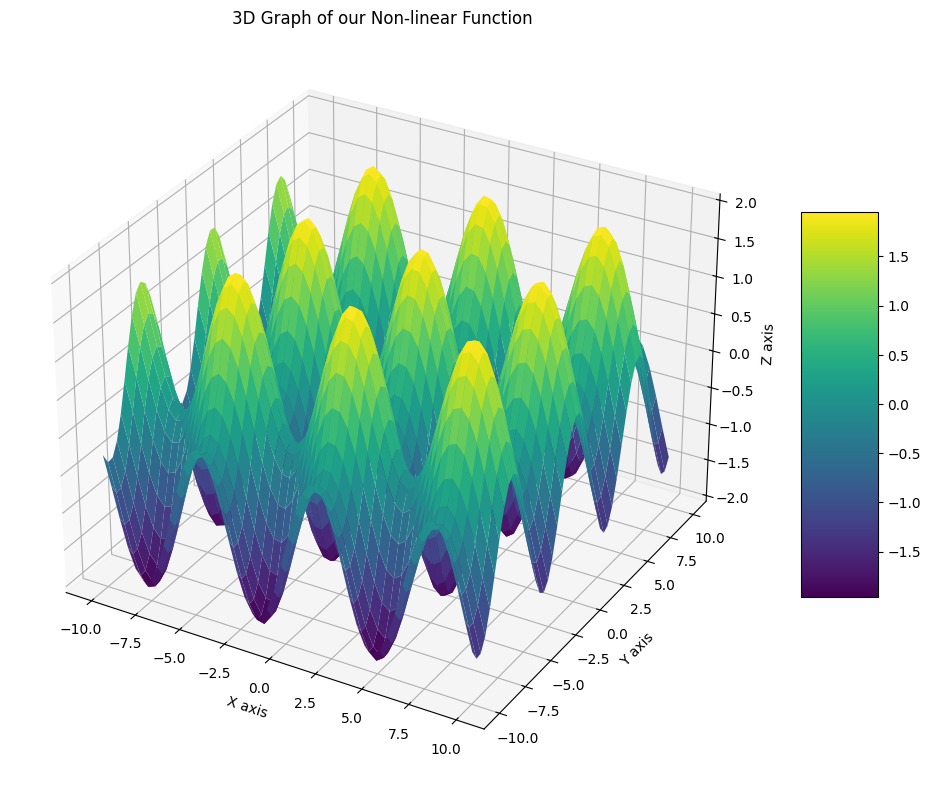

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
def safe_tan(x, clip_value=100):
    return np.clip(np.tan(x), -clip_value, clip_value)


def safe_sin(x):
    return np.sin(np.clip(x, -100, 100))

def safe_cos(x):
    return np.cos(np.clip(x, -100, 100))

def safe_tan(x):
    return np.clip(np.tan(np.clip(x, -1.5, 1.5)), -100, 100)
def nonlinear_function(x, y):
    return safe_sin(x) +  safe_cos(y)


def plot_surface():
    x = np.linspace(-10, 10, 50)
    y = np.linspace(-10, 10, 50)
    X, Y = np.meshgrid(x, y)
    Z = nonlinear_function(X, Y)

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot the surface
    surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
    
    # Add a color bar
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    
    # Set labels and title
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_title('3D Graph of our Non-linear Function')
    
    plt.show()




# Plot the surface of the function
plot_surface()



## Setting up a training loop

### First we will generate some data

In [27]:
def generate_data(num_samples=100000):
    x = np.random.uniform(-10, 10, (num_samples, 1))
    y = np.random.uniform(-10, 10, (num_samples, 1))
    inputs = np.hstack((x, y))
    outputs = nonlinear_function(x, y)
    return inputs,outputs

Creating a Neural Network designed for this problem

In [28]:
X,y = generate_data()


In [29]:
nn = MultiLayerPerceptron(2, hidden_layers = [32,64])

This is the training code, it's the same as the backpropagation code, however now it returns the loss and the output of the network

In [30]:
def train(nn,features,targets,learning_rate = .001):
    #ensure the target labels have the desired shape in regards to the model output
    targets = np.reshape(targets,(targets.shape[0], 1))
    current_input = features
    inputs = []
    
    #collect all of the inputs 
    inputs.append(features)
    for layer in nn.layers:
        
        current_input = layer.forward(current_input)
        inputs.append(current_input)
        current_input = nn.activation(current_input)
    
    # get the final output
    output = nn.output_layer.forward(current_input)
    # calculate the loss 
    loss = np.mean(mse_loss(targets,output))

    #compute the error yhat - y
    error = output - targets
    current_input = inputs.pop()
    final_layer_gradient = (2 / len(targets)) *  np.dot(nn.activation(current_input).T,error)
    nn.output_layer.weights -= learning_rate * final_layer_gradient
    nn.output_layer.bias -= learning_rate * (2 / len(targets)) * np.sum(error,axis=0)

    current_derivative = np.dot(error,nn.output_layer.weights.T) * nn.activation_derivative(current_input)
    current_input = inputs.pop()
    current_gradient = (2 / len(targets)) * np.dot(nn.activation(current_input).T,current_derivative)

    nn.layers[-1].weights -= learning_rate * current_gradient
    nn.layers[-1].bias -= learning_rate * (2 / len(targets)) * np.sum(current_derivative,axis=0)
    for i in reversed(range(len(nn.layers) - 1)):
        
        current_derivative = np.dot(current_derivative,nn.layers[i + 1].weights.T) * nn.activation_derivative(current_input)
        current_input = inputs.pop()
        current_gradient = (2 / len(targets)) * np.dot(current_input.T if i == 0 else nn.activation(current_input).T, current_derivative) 
        nn.layers[i].weights -= learning_rate * current_gradient
        nn.layers[i].bias -= learning_rate * (2 / len(targets)) * np.sum(current_derivative,axis = 0)
    return loss,output

In [31]:
def train(nn,features,targets,learning_rate = .01):
    #ensure the target labels have the desired shape in regards to the model output
    targets = np.reshape(targets,(targets.shape[0], 1))
    current_input = features
    inputs = []
    activations = []
    #collect all of the inputs 
    inputs.append(features)
    activations.append(features)
    for layer in nn.layers:
        
        current_input = layer.forward(current_input)
        inputs.append(current_input)
        current_input = nn.activation(current_input)
        activations.append(current_input)
    
    # get the final output
    output = nn.output_layer.forward(current_input)
    # calculate the loss 
    loss = np.mean(mse_loss(targets,output))

    #compute the error yhat - y
    error = output - targets
    current_input = inputs.pop()
    current_activation = activations.pop()
    final_layer_gradient = (2 / len(targets)) *  np.dot(current_activation.T,error)
    nn.output_layer.weights -= learning_rate * final_layer_gradient
    nn.output_layer.bias -= learning_rate * (2 / len(targets)) * np.sum(error,axis=0)

    current_derivative = np.dot(error,nn.output_layer.weights.T) * nn.activation_derivative(current_input)
    current_input = inputs.pop()
    current_activation = activations.pop()
    current_gradient = (2 / len(targets)) * np.dot(current_activation.T,current_derivative)

    nn.layers[-1].weights -= learning_rate * current_gradient
    nn.layers[-1].bias -= learning_rate * (2 / len(targets)) * np.sum(current_derivative,axis=0)
    for i in reversed(range(len(nn.layers) - 1)):
        
        current_derivative = np.dot(current_derivative,nn.layers[i + 1].weights.T) * nn.activation_derivative(current_input)
        current_input = inputs.pop()
        current_activation = activations.pop()
        current_gradient = (2 / len(targets)) * np.dot(current_activation.T, current_derivative) 
        nn.layers[i].weights -= learning_rate * current_gradient
        nn.layers[i].bias -= learning_rate * (2 / len(targets)) * np.sum(current_derivative,axis = 0)
    return loss,output

## Creating some testing data

Normally in Machine Learning we use an 80/20 split but because this is a custom function I'll only be taking the last 100 samples of our generated dataa

In [32]:
train_X,train_y = X[0:len(X) - 100],y[0:len(y) - 100]
test_X, test_y = X[-100:], y[-100:]

## Stochastic Gradient Descent


Unfortunately if we call train a single time, our test loss is going to be pretty tragic

In [33]:
single_loss,single_output= train(nn,train_X,train_y)

In [34]:
single_loss 

np.float64(3.956294681979771)

In [35]:
np.mean(mse_loss(np.reshape(test_y,(test_y.shape[0], 1)),nn.forward(test_X)))

np.float64(3.152645050760478)

In [36]:
max(y)

array([1.99998245])

With just a single iteration on our test data set had an MSE Loss greater than the maximum number in our entire dataset, that's pretty awful. This is where we introduce Stochastic Gradient Descent. Stochastic Gradient Descent gets around this problem by dividing the training data into random batches. By doing so the neural network can update the weights in small steps, and converge more effectively. The randomness also allows us to sample from all portions of the underlying function independantly. A single iteration is also often not sufficient to converge, so we will use many iterations called "epochs". 

## Batching
We will first begin by shuffling the dataset this time around.

In [37]:
def relu(x, epsilon=1e-7):
    return np.maximum(epsilon, x)

def relu_derivative(x, epsilon=1e-7):
    return np.where(x > epsilon, 1, epsilon)

In [38]:
#create a freshly untrained network
nn = MultiLayerPerceptron(2, hidden_layers = [32,64], activation = sigmoid,activation_derivative = sigmoid_derivative)

In [39]:
num_samples = len(X)
permutation = np.random.permutation(num_samples)
shuffled_X = X[permutation]
shuffled_y = y[permutation]

In [40]:
train_X,train_y = shuffled_X[0:len(X) - 2000],shuffled_y[0:len(y) - 2000]
test_X, test_y = shuffled_X[-2000:], shuffled_y[-2000:]

Neural networks oftentimes have issues converging without normalization. In this case

In [41]:
batch_size = 8
batched_train_X = np.array_split(train_X, np.ceil(len(train_X) / batch_size))
batched_train_y = np.array_split(train_y, np.ceil(len(train_X) / batch_size))

In [42]:
# train_X,train_y = X_batched[0:len(X) - 100],y_batched[0:len(y) - 100]
train_X[0],train_y[0]

(array([ 9.68651336, -7.011386  ]), array([0.48761586]))

## Training on 50 epochs

In [43]:
from tqdm import tqdm
epochs = 200
for _ in tqdm(range(epochs)):
    for x_batch,y_batch in zip(batched_train_X,batched_train_y):
        loss,output = train(nn,x_batch  ,y_batch)
    if not _ % 10:
        test_preds = nn.forward(test_X)  
        loss = np.mean(mse_loss(np.reshape(test_y,(test_y.shape[0], 1)),test_preds))
        print(f' train loss at epoch {_} is {loss}, test loss : {loss}')

  0%|▏                                          | 1/200 [00:01<03:36,  1.09s/it]

 train loss at epoch 0 is 0.524021451774438, test loss : 0.524021451774438


  6%|██▎                                       | 11/200 [00:11<03:25,  1.09s/it]

 train loss at epoch 10 is 0.028802540840024225, test loss : 0.028802540840024225


 10%|████▍                                     | 21/200 [00:22<03:13,  1.08s/it]

 train loss at epoch 20 is 0.012149887890892466, test loss : 0.012149887890892466


 16%|██████▌                                   | 31/200 [00:33<03:02,  1.08s/it]

 train loss at epoch 30 is 0.008778245174312352, test loss : 0.008778245174312352


 20%|████████▌                                 | 41/200 [00:44<02:52,  1.08s/it]

 train loss at epoch 40 is 0.00734871887086414, test loss : 0.00734871887086414


 26%|██████████▋                               | 51/200 [00:55<02:41,  1.08s/it]

 train loss at epoch 50 is 0.005815464987230093, test loss : 0.005815464987230093


 30%|████████████▊                             | 61/200 [01:06<02:30,  1.08s/it]

 train loss at epoch 60 is 0.004884670171381828, test loss : 0.004884670171381828


 36%|██████████████▉                           | 71/200 [01:16<02:20,  1.09s/it]

 train loss at epoch 70 is 0.004282320562426911, test loss : 0.004282320562426911


 40%|█████████████████                         | 81/200 [01:27<02:08,  1.08s/it]

 train loss at epoch 80 is 0.003823506928594845, test loss : 0.003823506928594845


 46%|███████████████████                       | 91/200 [01:38<01:57,  1.08s/it]

 train loss at epoch 90 is 0.003454712358000647, test loss : 0.003454712358000647


 50%|████████████████████▋                    | 101/200 [01:49<01:46,  1.08s/it]

 train loss at epoch 100 is 0.0031485656941256743, test loss : 0.0031485656941256743


 56%|██████████████████████▊                  | 111/200 [02:00<01:36,  1.08s/it]

 train loss at epoch 110 is 0.0028867684403161087, test loss : 0.0028867684403161087


 60%|████████████████████████▊                | 121/200 [02:11<01:25,  1.08s/it]

 train loss at epoch 120 is 0.0026569504351754247, test loss : 0.0026569504351754247


 66%|██████████████████████████▊              | 131/200 [02:21<01:14,  1.08s/it]

 train loss at epoch 130 is 0.002448498204898117, test loss : 0.002448498204898117


 70%|████████████████████████████▉            | 141/200 [02:32<01:03,  1.08s/it]

 train loss at epoch 140 is 0.002253170583778266, test loss : 0.002253170583778266


 76%|██████████████████████████████▉          | 151/200 [02:43<00:52,  1.08s/it]

 train loss at epoch 150 is 0.002069063183548951, test loss : 0.002069063183548951


 80%|█████████████████████████████████        | 161/200 [02:54<00:41,  1.08s/it]

 train loss at epoch 160 is 0.0018999078713650213, test loss : 0.0018999078713650213


 86%|███████████████████████████████████      | 171/200 [03:05<00:31,  1.08s/it]

 train loss at epoch 170 is 0.0017497976364877566, test loss : 0.0017497976364877566


 90%|█████████████████████████████████████    | 181/200 [03:15<00:20,  1.08s/it]

 train loss at epoch 180 is 0.0016201813610960535, test loss : 0.0016201813610960535


 96%|███████████████████████████████████████▏ | 191/200 [03:26<00:09,  1.08s/it]

 train loss at epoch 190 is 0.001509814895906263, test loss : 0.001509814895906263


100%|█████████████████████████████████████████| 200/200 [03:36<00:00,  1.08s/it]


In [44]:
np.mean(mse_loss(np.reshape(test_y,(test_y.shape[0], 1)),nn.forward(test_X)))

np.float64(0.0014245636965557864)

As you can see on just 200 epochs using Stochastic Gradient Descent, our loss has been cut by 3

### Graphing Convergence

Graphing the predictions over a set boundary in comparsion to the true function we can get a view of how the Network converges

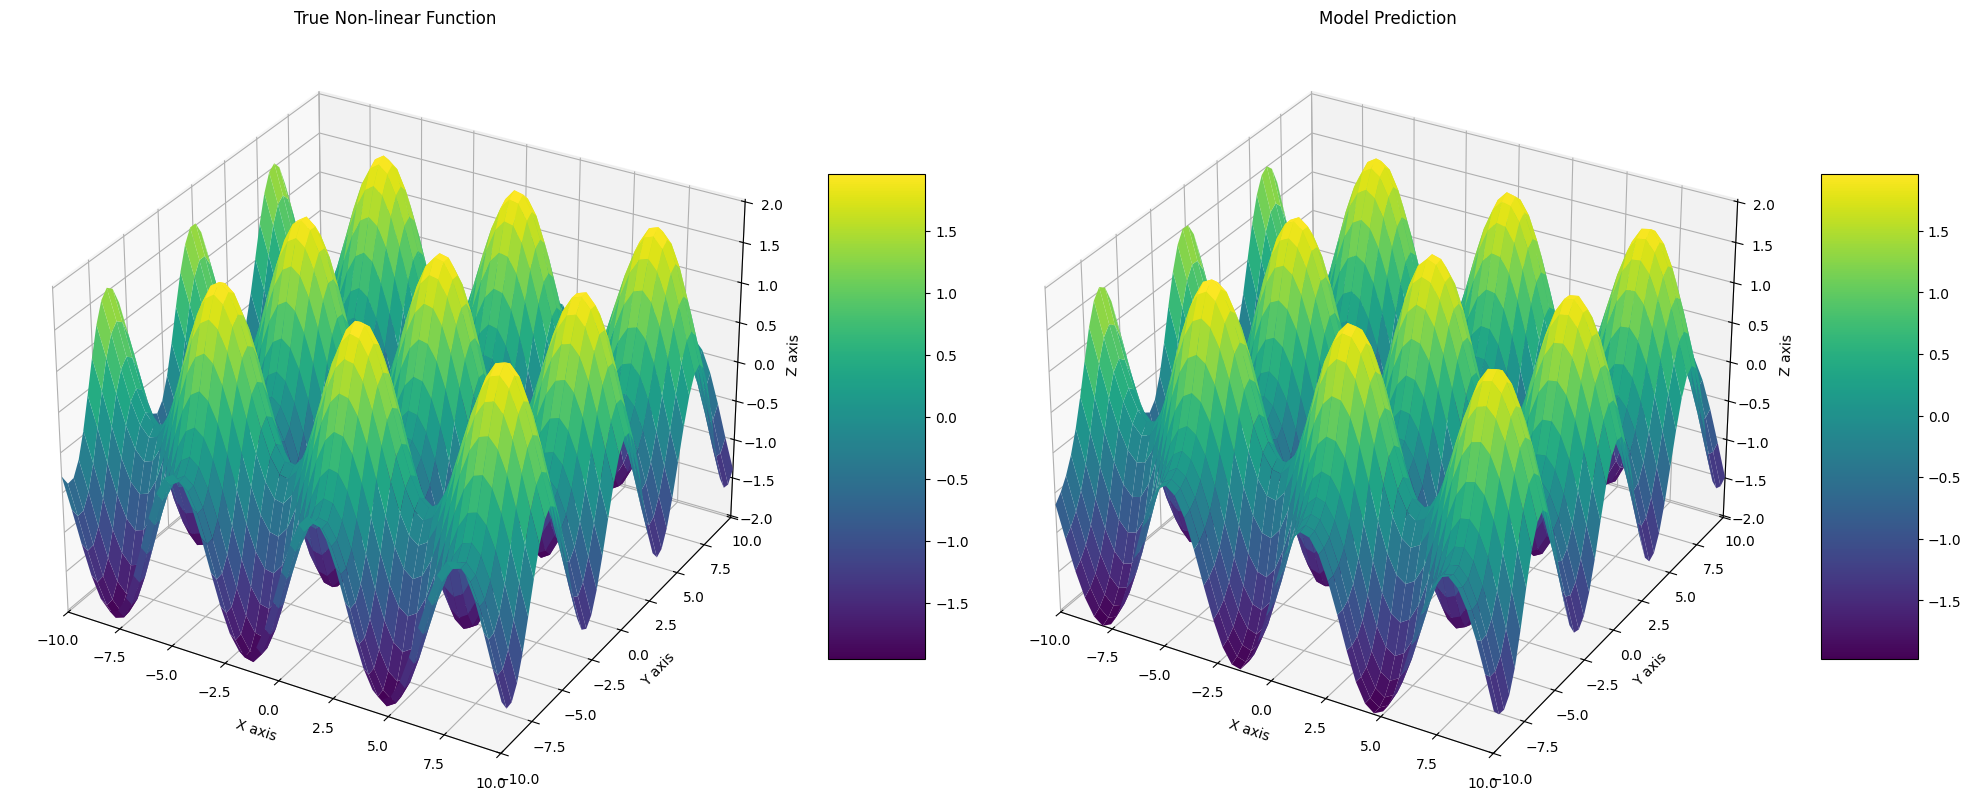

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function to plot the surface
def plot_surface(nn):
    x = np.linspace(-10, 10, 50)
    y = np.linspace(-10, 10, 50)
    X, Y = np.meshgrid(x, y)
    
    # True function
    Z_true = nonlinear_function(X,Y)
    
    # Model prediction
    XY = np.column_stack((X.ravel(), Y.ravel()))

    Z_pred = (nn.forward(XY) )
  

    Z_pred = np.reshape(Z_pred,Z_true.shape)
    fig = plt.figure(figsize=(20, 10))
    
    # True function plot
    ax1 = fig.add_subplot(121, projection='3d')
    surf1 = ax1.plot_surface(X, Y, Z_true, cmap='viridis', edgecolor='none')
    ax1.set_xlabel('X axis')
    ax1.set_ylabel('Y axis')
    ax1.set_zlabel('Z axis')
    ax1.set_title('True Non-linear Function')
    fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)
    
    # Model prediction plot
    ax2 = fig.add_subplot(122, projection='3d')
    surf2 = ax2.plot_surface(X, Y, Z_pred, cmap='viridis', edgecolor='none')
    ax2.set_xlabel('X axis')
    ax2.set_ylabel('Y axis')
    ax2.set_zlabel('Z axis')
    ax2.set_title('Model Prediction')
    fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5)
    
    # Set the same limits for both plots
    x_lim = (-10, 10)
    y_lim = (-10, 10)
    z_min = min(Z_true.min(), Z_pred.min())
    z_max = max(Z_true.max(), Z_pred.max())
    z_lim = (z_min, z_max)
    
    ax1.set_xlim(x_lim)
    ax1.set_ylim(y_lim)
    ax1.set_zlim(z_lim)
    ax2.set_xlim(x_lim)
    ax2.set_ylim(y_lim)
    ax2.set_zlim(z_lim)
    
    plt.tight_layout()
    plt.show()

# Plot the surfaces
plot_surface(nn)


